In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import torch as tch
from torch.distributions.beta import Beta
from torch.distributions.gamma import Gamma

## Question 1 - Newton's Method

In [2]:
def newton_method(f, fp, x0, eps, maxiter=5000):
  """
  Implements the Newton-Rhapson Method

  args:
    f (func, lambda expr): function of x
    fp (func, lambda expr): derivative of f
    x0 (float): starting value
    eps (float): tolerance

  """
  for i in range(maxiter):
    x1 = x0 - f(x0)/fp(x0)

    if np.abs(x0 - x1) < eps:
      print("Root found at {}".format(x1)) 
      return x1

    x0 = x1

Consider $f_1(x) = x^3 - 25x^2 + 75x + 100$, for $x \in [-10, 10]$. The derivative of $f_1(x)$ is given by $f^{'}_1(x) = 3x^2 - 50x + 75$, for $x \in [-10, 10]$.

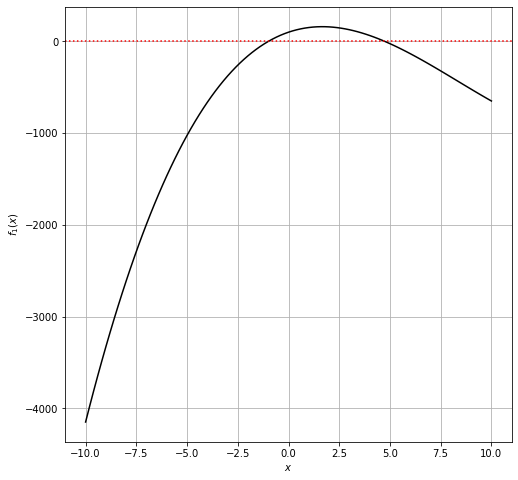

In [3]:
f1 = lambda x: x**3 - 25*x**2 + 75*x + 100
fp1 = lambda x: 3*x**2 - 50*x + 75
x = np.linspace(-10, 10, 101)

plt.figure(figsize=(8,8))
plt.plot(x, f1(x), c='k')
plt.xlabel("$x$")
plt.ylabel("$f_1(x)$")
plt.grid()
plt.axhline(0, c='r', linestyle=':');

The roots appear to be near -1 and 5. We will use these as starting points for Newton's Method.

Root found at -0.9921741064862007
Root found at 4.743238055731016


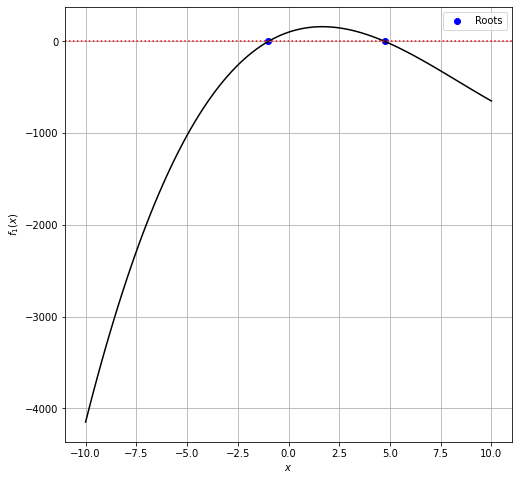

In [4]:
root1 = newton_method(f1, fp1, -1, 1e-6)
root2 = newton_method(f1,fp1, 5, 1e-6)

plt.figure(figsize=(8,8))
plt.plot(x, f1(x), c='k')
plt.scatter([root1, root2], [f1(root1), f1(root1)], c='b', label='Roots')
plt.xlabel("$x$")
plt.ylabel("$f_1(x)$")
plt.grid()
plt.legend()
plt.axhline(0, c='r', linestyle=':');

Next, we consider $f_2(x) = \cos (x)$, for $x \in [0, 2\pi]$. The derivative is given by $f^{'}_2(x) = -\sin (x)$, for $x \in [0, 2\pi]$.

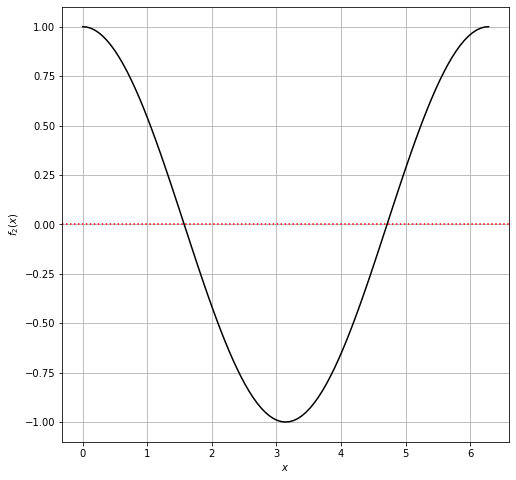

In [5]:
f2 = lambda x: np.cos(x)
fp2 = lambda x: -np.sin(x)
x = np.linspace(0, 2*np.pi, 101)

plt.figure(figsize=(8,8))
plt.plot(x, f2(x), c='k')
plt.xlabel("$x$")
plt.ylabel("$f_2(x)$")
plt.grid()
plt.axhline(0, c='r', linestyle=':');

The roots of $f_2(x)$ are located at $x = \frac{\pi}{2}$ and $x = \frac{3\pi}{2}$. We will use 2 and 5 as starting points for Newton's method.

Root found at 1.5707963267948966
Root found at 4.71238898038469


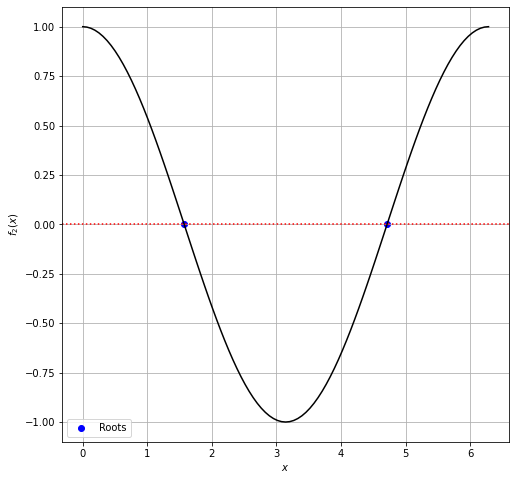

In [6]:
root1 = newton_method(f2, fp2, 2, 1e-6)
root2 = newton_method(f2, fp2, 5, 1e-6)

plt.figure(figsize=(8,8))
plt.plot(x, f2(x), c='k')
plt.scatter([root1, root2], [f2(root1), f2(root2)], c='b', label='Roots')
plt.xlabel("$x$")
plt.ylabel("$f_2(x)$")
plt.grid()
plt.legend()
plt.axhline(0, c='r', linestyle=':');

## Question 3 - Method of Moments: Beta Distribution

In [7]:
def method_of_moments_beta(x):
  """
  Returns the method of moments
  estimator for the alpha parameter of
  a Beta distribution for a set of data,
  x.

  """
  x_bar = np.mean(x)
  var_x_bar = np.var(x)

  alpha_hat = x_bar*(x_bar*(1-x_bar)/var_x_bar - 1)

  return alpha_hat

In [8]:
n = 100
alpha = 5
beta = 5
reps = 500
beta_rvs = np.random.beta(alpha, beta, (reps, n))

# Method of Moments
fitted_alphas = np.apply_along_axis(method_of_moments_beta, 
                                    1, beta_rvs)
mse = np.mean((fitted_alphas - alpha)**2)
bias = np.mean(fitted_alphas - alpha)
variance = mse - bias**2
print("MSE: {}  Bias: {}  Variance: {}".format(mse, bias, variance))

MSE: 0.6084877048366822  Bias: 0.11261654846859112  Variance: 0.5958052178477037


## Question 5 - MLE: Beta Distribution

In [9]:
def mle_beta(x, beta):
  """
  Fits the alpha parameter of a Beta
  distribution using torch. Assumes beta param
  is known.

  """
  alpha_hat = tch.nn.Parameter(tch.ones(x.shape[0]), requires_grad=True)
  optimizer = tch.optim.Adam([alpha_hat], lr=0.05)

  for optimization_step in range(3000):
    nll = -1*tch.sum(Beta(alpha_hat, beta).log_prob(x.T))
    nll.backward()
    optimizer.step()
    optimizer.zero_grad()

    alpha_hat.clamp(1e-16, 100.) # make sure alpha > 0
  
  return alpha_hat.detach().numpy()

In [10]:
n = 100
alpha = 5
beta = 5
reps = 500
beta_rvs = np.random.beta(alpha, beta, (reps, n))
beta_rvs_tch = tch.tensor(beta_rvs)

# MLE
fitted_alphas = mle_beta(beta_rvs_tch, beta)
mse = np.mean((fitted_alphas - alpha)**2)
bias = np.mean(fitted_alphas - alpha)
variance = mse - bias**2
print("MSE: {}  Bias: {}  Variance: {}".format(mse, bias, variance))

MSE: 0.08173155039548874  Bias: 0.022451335564255714  Variance: 0.08122748792686993


## Question 6 - MM and MLE: Gamma Distribution

In [11]:
def method_of_moments_gamma(x):
  """
  Computes the method of moments estimate
  of the \beta parameter of a Gamma distributed
  r.v., assuming \alpha is known.

  args:
    x (array): sample
  
  """
  beta_hat = x.var() / x.mean()

  return beta_hat

def mle_gamma(x, alpha):
  """
  Fits the \beta parameter of a gamma distributed
  r.v. using MLE, assuming \alpha is known.

  args:
    x (tensor): sample
    alpha (float): known alpha parameter
  
  """
  beta_hat = tch.nn.Parameter(tch.ones(x.shape[0]), requires_grad=True)
  optimizer = tch.optim.Adam([beta_hat], lr=0.05)

  for optimization_step in range(3000):
    nll = -1.*tch.sum(Gamma(alpha, beta_hat).log_prob(x.T))
    nll.backward()
    optimizer.step()
    optimizer.zero_grad()

    beta_hat.clamp(1e-16, 100.)

  return beta_hat.detach().numpy()

In [12]:
n = 100
reps = 500
alpha = 5.0
beta = 10.0

gamma_rv = np.random.gamma(alpha, beta, size=(reps, n))
gamma_rv_tch = tch.tensor(gamma_rv)

# Method of moments
beta_hat_mm = np.apply_along_axis(method_of_moments_gamma, 1, gamma_rv)
mse = np.mean((beta_hat_mm - beta)**2)
bias = np.mean(beta_hat_mm - beta)
variance = mse - bias**2
print("Method of Moments:")
print('\t', "MSE: {}  Bias: {}  Variance: {}".format(mse, bias, variance))
print('\n')

# MLE
beta_hat_mle = 1 / mle_gamma(gamma_rv_tch, alpha=alpha)
mse = np.mean((beta_hat_mle - beta)**2)
bias = np.mean(beta_hat_mle - beta)
variance = mse - bias**2
print("Maximum likelihood:")
print('\t', "MSE: {}  Bias: {}  Variance: {}".format(mse, bias, variance))

Method of Moments:
	 MSE: 2.5259686503422194  Bias: -0.09169368276130294  Variance: 2.517560918883889


Maximum likelihood:
	 MSE: 0.22292326390743256  Bias: 0.03789908066391945  Variance: 0.2214869235922623


## Question 7 - Mixture Distributions

In [13]:
# Mean and std. deviation
mu = np.random.normal(0, 2, size=10)
sigma = np.random.gamma(2, 8, size=10)

# Sample 10 normal distributions 250 times each
X = np.random.normal(mu, sigma, size=(250, 10))
Y = 0.1*X.sum(axis=1)

In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.75)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(xtrain, ytrain)
y_pred = knn.predict(xtest)

In [15]:
# Accuracy of the classification 
sum((ytest >= 0.5) == (y_pred >= 0.5)) / len(ytest)

0.873015873015873